# Forward_Forward algorithm

In [1]:
student_id =  400101034
student_name = 'Hesam Hosseini'

print("your student id:", student_id)
print("your name:", student_name)

your student id: 400101034
your name: Hesam Hosseini


## Supervised

### Importing libarary

In [2]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import  Compose, ToTensor, Normalize, Lambda
from torch.nn import Module, Linear
from torch.nn.functional import one_hot
from tqdm.notebook import tqdm
from abc import ABC
from typing import List, Callable, Tuple

### a)Loading dataset

In [5]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

train_dataset = MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data/', train=False, transform=transform, download=True)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
device

device(type='cuda')

### b)*Data* generation

In [48]:
def gen_pos_neg(X, label, only_positive):
    X_pos = X.clone()
    X_pos[:, :10] *= 0.0
    X_pos[range(X.shape[0]), label] = X_pos.max()

    if only_positive:
        return X_pos
    else:
        X_neg = X.clone()
        rand = torch.randperm(X_neg.size(0))
        label_neg = label[rand]
        X_neg[:, :10] *= 0.0
        X_neg[range(X_neg.shape[0]), label_neg] = X_neg.max()

        return X_pos, X_neg
class TrainingDatasetFF(Dataset):
    def __init__(self, dataset_generator):
        with torch.no_grad():
            self.dataset = [
                batch
                for X_pos, X_neg in dataset_generator
                for batch in zip(X_pos, X_neg)
            ]

    def __getitem__(self, index: int):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

train_dataloader_ff = DataLoader(TrainingDatasetFF(gen_pos_neg(X.to(device),Y.to(device), False) for X, Y in tqdm(train_dataloader)),batch_size=train_dataloader.batch_size, shuffle=True)

  0%|          | 0/938 [00:00<?, ?it/s]

### c)Network implementation

In [57]:
class FFMultiLayerPerceptron(Module):
    def __init__(self, hidden_dimensions, activation, optimizer, learning_rate, threshold, loss_fn):
        super(FFMultiLayerPerceptron, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(hidden_dimensions) - 1):
            self.layers += [FFLinear(hidden_dimensions[i],
                                     hidden_dimensions[i + 1],
                                     activation,
                                     optimizer,
                                     learning_rate,
                                     threshold,
                                     loss_fn).cuda()]

    def predict(self, X, pos_gen_fn, n_class= None):
        goodness_of_labels = []
        for label in range(n_class):
            h = pos_gen_fn(X, label, True)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_of_labels += [sum(goodness).unsqueeze(1)]
        goodness_of_labels = torch.cat(goodness_of_labels, 1)
        return goodness_of_labels.argmax(1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def train_batch(self, X_pos, X_neg, before=False):
        layers_losses = []

        for layer in self.layers:
            X_pos, X_neg, layer_loss = layer.train_layer(
                X_pos, X_neg, before=before)
            layers_losses.append(layer_loss)
        return layers_losses

class FFLinear(Linear):
    def __init__(self, in_features, out_features, activation, optimizer, learning_rate, threshold, loss_fn, bias=True):
        super(FFLinear, self).__init__(in_features, out_features, bias)
        self.activation = activation
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.threshold = threshold
        self.loss_fn = loss_fn

    def forward(self, x):
        x = x / (x.norm(2, 1, keepdim=True) + 1e-8)
        return self.activation(torch.mm(x, self.weight.T) + self.bias.unsqueeze(0))

    def train_layer(self, X_pos, X_neg, before):
        X_pos_out = self.forward(X_pos)
        X_neg_out = self.forward(X_neg)
        loss = self.loss_fn(X_pos_out, X_neg_out, self.threshold)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if before:
            return X_pos_out.detach(), X_neg_out.detach(), loss.item()
        else:
            return self.forward(X_pos).detach(), self.forward(X_neg).detach(), loss.item()

#### why the loss function below satisfies the goodness necessary condition

beacuse pushes pos (neg) samples to values larger (smaller) than the threshold.

which makes $p(\text { positive })=\sigma\left(\sum_j y_j^2-\theta\right)$ larger(closer to 1) for actual pos samples and smaller for actual neg samples (closer to 0)


In [53]:
def base_loss(X_pos, X_neg, th):
    logits_pos = X_pos.pow(2).mean(dim=1)
    logits_neg = X_neg.pow(2).mean(dim=1)

    loss_pos = - logits_pos + th
    loss_neg = logits_neg - th

    loss_poss = torch.log(1 + torch.exp(loss_pos)).mean()
    loss_neg = torch.log(1 + torch.exp(loss_neg)).mean()

    loss = loss_poss + loss_neg

    return loss


### Defining model

In [58]:
hidden_dimensions = [784, 512, 512]
activation = torch.nn.ReLU()
learning_rate = 0.09
optimizer = torch.optim.Adam
threshold = 9.0
loss = base_loss

mlp_model = FFMultiLayerPerceptron(hidden_dimensions,
                                  activation,
                                  optimizer,
                                  learning_rate,
                                  threshold,
                                  loss).to(device)

### train

In [59]:
n_epochs = 60
for epoch in tqdm(range(n_epochs)):
    for X_pos, X_neg in train_dataloader_ff:
        layer_losses = mlp_model.train_batch(X_pos, X_neg, before=False)

  0%|          | 0/60 [00:00<?, ?it/s]

### d) result report

### test

accuracy on train dataset

In [ ]:
acc = 0
for X_train, Y_train in tqdm(train_dataloader):
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    acc += (mlp_model.predict(X_train,gen_pos_neg, n_class=10).eq(Y_train).sum())

print(f"Accuracy on train dataset: {acc/float(len(train_dataset)):.4%}")

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy: 97.8450%


accuracy on test dataset

In [61]:
acc = 0
for X_test, Y_test in tqdm(test_dataloader):
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    acc += (mlp_model.predict(X_test,gen_pos_neg, n_class=10).eq(Y_test).sum())

print(f"Accuracy on test dataset: {acc/float(len(test_dataset)):.4%}")

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test dataset: 95.7300%


### explanation

The Forward-Forward is a new method to train neural networks. Instead of making Backpropagation which requieres an inference step and then an optimization step it works by performing two forward steps: one with “positive data” and one with “negative data”.

Positive data means data that is correctly labeled and negative data means the opposite, data with the wrong label.

this step is done by function `gen_pos_neg`

The positive pass aims to adjust weights in order to increase a given measure of goodness in every hidden layer while the negative pass targets the decrease of goodness in every hidden layer.

The learning process consists in making goodness be well above certain threshold for real data and well below for negative data

the loss function is `base_loss` I explained there why it can be used as a mesure of goodness

in the trainind when chaining multiple layers, since we want to avoid seeing high activations just because we pumped in high inputs from a very excited previous layer. So layer activations are `normalized` (divided by the norm of the activation vector) between layers. (see forward function )

at the `predict fucntion` measures the results produced by each layer, and then finding the label with the highest values by measuring the ‘goodness’ of the images for all labels.

by changaing the theta value to higher value the accrecy improved a little

## unsupervised

### Other needed libraray

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

### a) Defining proper mask

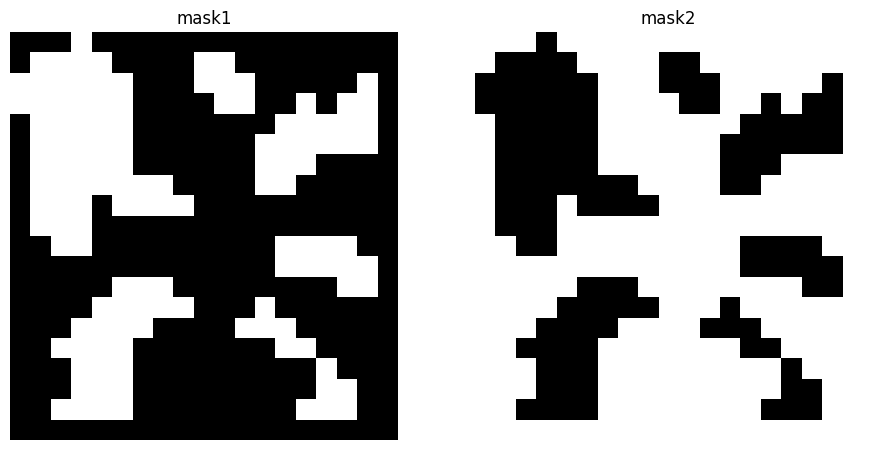

In [142]:
def create_mask(shape, iterations = 10):
    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    image = np.random.randint(0, 2, size=shape)

    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    mask = np.round(image).astype(np.uint8)
    return torch.tensor(mask) ,torch.tensor(1-mask)

mask1 , mask2 = create_mask((20,19),2)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(11,10))
ax[0].imshow(mask1,cmap='gray')
ax[0].axis('off')
ax[0].set_title('mask1')
ax[1].imshow(mask2,cmap='gray')
ax[1].axis('off')
ax[1].set_title('mask2');

as you can see the two mask are just how the article said

### b) Data generation

here gen_pos_neg_un is different from before

In [143]:
def gen_pos_neg_un(X, only_positive):
    if only_positive:
      return X
    # batch = batch[0]
    indexes = torch.randperm(X.shape[0])
    x1 = X
    x2 = X[indexes]
    mask1 ,mask2 = create_mask((int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))),2)
    merged_x1 = x1*mask1.flatten().cuda()
    merged_x2 = x2*mask2.flatten().cuda()
    X_neg = merged_x1+merged_x2
    return X, X_neg
class TrainingDatasetFF(Dataset):
    def __init__(self, dataset_generator):
        with torch.no_grad():
            self.dataset = [
                batch
                for X_pos, X_neg in dataset_generator
                for batch in zip(X_pos,X_neg)
            ]

    def __getitem__(self, index: int):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

train_dataloader_ffUN = DataLoader(TrainingDatasetFF(gen_pos_neg_un(X.to(device), False) for X, Y in tqdm(train_dataloader)),
                                batch_size=train_dataloader.batch_size, shuffle=True)

  0%|          | 0/938 [00:00<?, ?it/s]

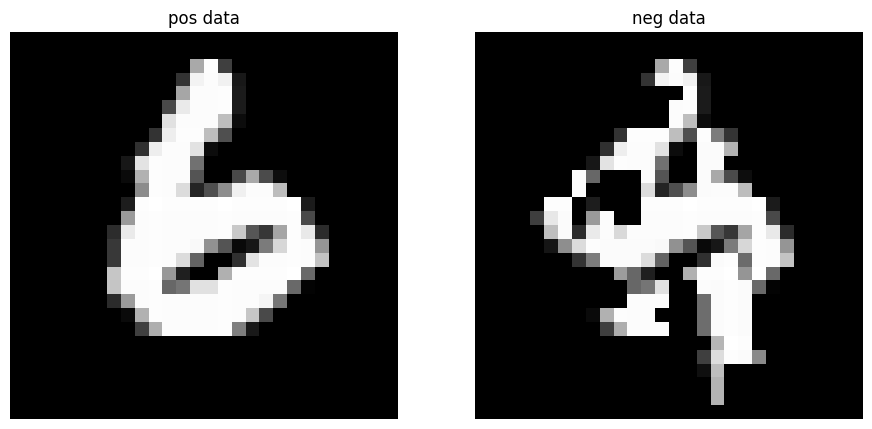

In [155]:
X_pos,X_neg = next(iter(train_dataloader_ffUN))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(11,10))
ax[0].imshow(X_pos[0].cpu().reshape((28,28)),cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'pos data')
ax[1].imshow(X_neg[0].cpu().reshape((28,28)),cmap='gray')
ax[1].axis('off')
ax[1].set_title('neg data');

### c) Network implementation

the only diffrent is predict function so we inhereted from the supervised FFnetwork

In [156]:
class FFMultiLayerPerceptronUN(FFMultiLayerPerceptron):
    def __init__(self, hidden_dimensions, activation, optimizer, learning_rate, threshold, loss_fn):
        super(FFMultiLayerPerceptronUN, self).__init__( hidden_dimensions, activation, optimizer, learning_rate, threshold, loss_fn)

    def predict(self, X):
        Z = []
        h = X
        for layer in self.layers:
          h = layer(h)
          Z.append(h)
        return torch.cat(Z, dim=-1)


### train FFUN network

here we use more hidden layer since unsupervised task is harder than supervised

I tested the result with two hidden layer and teh accuracy droped by 5 percent

In [158]:
hidden_dimensions = [784, 512, 512, 512]
activation = torch.nn.ReLU()
learning_rate = 0.09
optimizer = torch.optim.Adam
threshold = 9
loss = base_loss

mlp_model = FFMultiLayerPerceptronUN(hidden_dimensions,
                                  activation,
                                  optimizer,
                                  learning_rate,
                                  threshold,
                                  loss).to(device)

In [159]:
n_epochs = 60
for epoch in tqdm(range(n_epochs)):
    for X_pos, X_neg in train_dataloader_ffUN:
        layer_losses = mlp_model.train_batch(X_pos, X_neg, before=False)

  0%|          | 0/60 [00:00<?, ?it/s]

### d)linear classifier

In [161]:
X_pos, X_neg = next(iter(train_dataloader_ffUN))
X_train = mlp_model.predict(X_pos)
X_train.shape

torch.Size([64, 1536])

In [162]:
class TrainingDatasetFF(Dataset):
    def __init__(self, dataset_generator):
        with torch.no_grad():
            self.dataset = [
                batch
                for X,Y in dataset_generator
                for batch in zip(X,Y)
            ]

    def __getitem__(self, index: int):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

train_dataloader_linear = DataLoader(TrainingDatasetFF((mlp_model.predict(X.to(device)),Y.to(device)) for X, Y in tqdm(train_dataloader)),
                                batch_size=train_dataloader.batch_size, shuffle=True)
test_dataloader_linear = DataLoader(TrainingDatasetFF((mlp_model.predict(X.to(device)),Y.to(device)) for X, Y in tqdm(test_dataloader)),
                                    batch_size=test_dataloader.batch_size, shuffle=True)


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [163]:
x,y = next(iter(train_dataloader_linear))
print(x.shape)
model = torch.nn.Sequential(
    torch.nn.Linear(in_features = x.shape[1], out_features = 10).cuda(),
    torch.nn.Softmax(dim=1).cuda()
)

torch.Size([64, 1536])


### train linear classifier

In [164]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 60
for epoch in tqdm(range(n_epochs)):
  for X,Y in train_dataloader_linear:
      optimizer.zero_grad()
      y_pred = model(X)
      loss = criterion(y_pred, Y)
      loss.backward()
      optimizer.step()

  0%|          | 0/60 [00:00<?, ?it/s]

### report resault

### test linear classifier

In [188]:
with torch.no_grad():
  acc = 0
  i = 0
  for X_train, Y_train in tqdm(train_dataloader):
      X_train = X_train.to(device)
      Y_train = Y_train.to(device)
      Z =  mlp_model.predict(X_train)
      y_pred = model(Z)
      _, predicted = torch.max(y_pred, dim=1)

      acc += predicted.eq(Y_train).sum()

print(f'Accuracy on train dataset: {100*acc.item()/(len(train_dataloader)*train_dataloader.batch_size):.4f}')

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy on train dataset: 95.6723


In [187]:
with torch.no_grad():
  acc = 0
  for X_test, Y_test in tqdm(test_dataloader):
      X_test = X_test.to(device)
      Y_test = Y_test.to(device)
      Z =  mlp_model.predict(X_test)
      y_pred = model(Z)
      _, predicted = torch.max(y_pred, dim=1)
      acc += predicted.eq(Y_test).sum()
  print(f'Accuracy on test dataset: {100*acc.item()/(len(test_dataloader)*test_dataloader.batch_size):.4f}')

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test dataset: 93.9391


### explanation

the FF network nearly stays the same as before so we used inherentence
the only diffrence is `predict` fucntion since we don't have any label here we return hidden layers feature which can later be used as the input of our `linear classifier` as the paper suggested later the linear classifier is trained on the new dataloader and batches you can see the hyperparameted used in the network